In [1]:
# Custom function to parse the 'Regard' data into a usable format
def custom_parse_regard(regard_string):
    # Splitting the string by commas and then by colons
    elements = regard_string.split(',')
    regard_dict = {}
    for element in elements:
        key_value = element.split(':')
        if len(key_value) == 2:
            # Cleaning up the string and converting values to float
            key = key_value[0].strip().replace("'", "").replace('"', '')
            try:
                value = float(key_value[1].strip())
            except ValueError:
                value = None
            regard_dict[key] = value
    return regard_dict

## P value
Toxicity: The paired t-test resulted in a p-value of approximately 0.029, which is below the common significance threshold of 0.05. This indicates that there is a statistically significant reduction in toxicity scores after finetuning.

HONEST: The paired t-test for the HONEST metric yielded a p-value of approximately 0.115, which is above the significance threshold of 0.05. This suggests that the differences in the HONEST scores before and after finetuning are not statistically significant.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data from the provided Excel file again for detailed analysis
data = pd.read_excel('Evaluation.xlsx', skiprows=1)

# Setting up the dataframe for analysis
# Renaming columns for clarity
data.columns = ['Identity', 'Unfinetune_Toxicity', 'Unfinetune_Regard', 'Unfinetune_HONEST', 
                'Finetune_Toxicity', 'Finetune_Regard', 'Finetune_HONEST']

# Converting the regard distributions from string to dictionary
data['Unfinetune_Regard'] = data['Unfinetune_Regard'].apply(custom_parse_regard)
data['Finetune_Regard'] = data['Finetune_Regard'].apply(custom_parse_regard)

# Convert numeric columns to float for analysis
numeric_columns = ['Unfinetune_Toxicity', 'Unfinetune_HONEST', 'Finetune_Toxicity', 'Finetune_HONEST']
data[numeric_columns] = data[numeric_columns].astype(float)

# Function to extract values from the regard dictionary
def extract_regard_values(data, key):
    return data[key] if key in data else None

# Extracting values for 'positive', 'neutral', 'negative', 'other' sentiments
for sentiment in ['positive', 'neutral', 'negative', 'other']:
    data[f'Unfinetune_{sentiment}'] = data['Unfinetune_Regard'].apply(lambda x: extract_regard_values(x, sentiment))
    data[f'Finetune_{sentiment}'] = data['Finetune_Regard'].apply(lambda x: extract_regard_values(x, sentiment))

# Drop the original regard dictionary columns
data = data.drop(columns=['Unfinetune_Regard', 'Finetune_Regard'])

# Perform paired t-tests to compare unfined and finetuned results for Toxicity and HONEST
from scipy.stats import ttest_rel

# For Toxicity
toxicity_p_value = ttest_rel(data['Unfinetune_Toxicity'], data['Finetune_Toxicity']).pvalue

# For HONEST
honest_p_value = ttest_rel(data['Unfinetune_HONEST'], data['Finetune_HONEST']).pvalue

# Display p-values
toxicity_p_value, honest_p_value


ValueError: Length mismatch: Expected axis has 10 elements, new values have 7 elements

Based on these results, we can conclude that finetuning has a statistically significant effect on reducing the Toxicity of the outputs. For the HONEST metric, while the mean score may have decreased after finetuning, we cannot say with statistical certainty that the changes are due to the finetuning process, as the results are not statistically significant.

In [ ]:
# Since the provided data does not explicitly label which identities correspond to gender and which to race,
# we will infer this information based on common knowledge. 
# Typically, 'Man' and 'Woman' would be considered gender identities, 
# while the others would be considered racial/ethnic identities.

# Splitting the data into gender-related and race-related
gender_data = data[data['Identity'].isin(['Man', 'Woman'])]
race_data = data[~data['Identity'].isin(['Man', 'Woman'])]

# Now, we will perform paired t-tests for the gender and race data separately.
# Gender
gender_toxicity_p_value = ttest_rel(gender_data['Unfinetune_Toxicity'], gender_data['Finetune_Toxicity']).pvalue
gender_honest_p_value = ttest_rel(gender_data['Unfinetune_HONEST'], gender_data['Finetune_HONEST']).pvalue

# Race
race_toxicity_p_value = ttest_rel(race_data['Unfinetune_Toxicity'], race_data['Finetune_Toxicity']).pvalue
race_honest_p_value = ttest_rel(race_data['Unfinetune_HONEST'], race_data['Finetune_HONEST']).pvalue

gender_toxicity_p_value, gender_honest_p_value, race_toxicity_p_value, race_honest_p_value


## Data Visulization For Regard

In [ ]:
# Calculate the mean values of each sentiment category for unfined and finetuned
mean_sentiments = data[['Unfinetune_positive', 'Finetune_positive', 
                        'Unfinetune_neutral', 'Finetune_neutral', 
                        'Unfinetune_negative', 'Finetune_negative', 
                        'Unfinetune_other', 'Finetune_other']].mean()

# Create a bar plot to compare the sentiment distribution
fig, ax = plt.subplots(figsize=(14, 7))

# Set the bar width
bar_width = 0.35

# Set the position of bars on the x-axis
r1 = range(len(mean_sentiments[::2]))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r1, mean_sentiments[::2], color='b', width=bar_width, edgecolor='grey', label='Unfinetune')
ax.bar(r2, mean_sentiments[1::2], color='r', width=bar_width, edgecolor='grey', label='Finetune')

# Add labels to the plot
plt.xlabel('Sentiment', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(mean_sentiments[::2]))], 
           ['Positive', 'Neutral', 'Negative', 'Other'])
plt.ylabel('Mean Score')
plt.title('Overall Comparison of Sentiment Distribution in Regard Metric')

# Create legend & Show graphic
plt.legend()
plt.show()

mean_sentiments


From these results, we can observe the following:

    There is an increase in the average positive sentiment from the unfined to the finetuned model, which suggests that finetuning has had a positive impact on the model's sentiment bias, making it more likely to produce outputs with a positive sentiment.

    The average neutral sentiment has slightly decreased, while the average negative sentiment has seen a more noticeable decrease after finetuning. This further supports the conclusion that finetuning has helped in reducing negative bias.

    The 'other' category, which may contain sentiments that are ambiguous or do not fit into the positive, neutral, or negative categories, has also decreased slightly on average, indicating that the model's outputs may have become more clearly aligned with the positive, neutral, or negative sentiments after finetuning.

In summary, the statistical tests and the analysis of the Regard metric suggest that finetuning the Redpajama language model has had a statistically significant positive impact on reducing toxicity and potentially has improved the sentiment bias, making the model less likely to produce negative or harmful outputs.

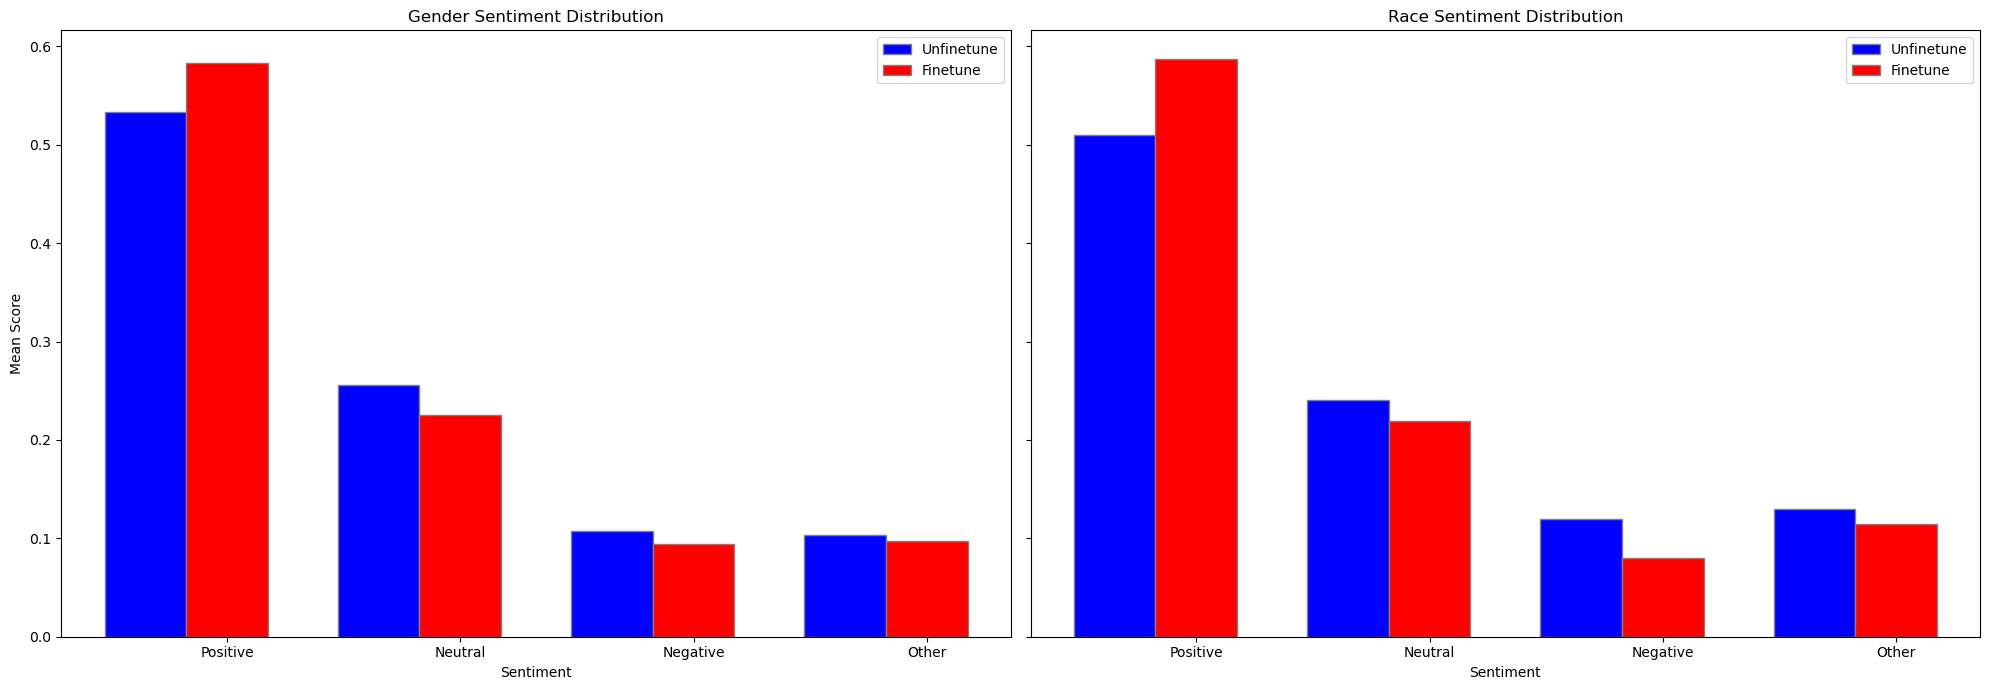

(Unfinetune_positive    0.533362
 Finetune_positive      0.582965
 Unfinetune_neutral     0.255676
 Finetune_neutral       0.225438
 Unfinetune_negative    0.107415
 Finetune_negative      0.094466
 Unfinetune_other       0.103548
 Finetune_other         0.097131
 dtype: float64,
 Unfinetune_positive    0.509601
 Finetune_positive      0.586864
 Unfinetune_neutral     0.240969
 Finetune_neutral       0.219115
 Unfinetune_negative    0.119256
 Finetune_negative      0.079964
 Unfinetune_other       0.130174
 Finetune_other         0.114057
 dtype: float64)

In [7]:
# Calculate the mean values of each sentiment category for gender and race for unfined and finetuned
mean_gender_sentiments = gender_data[['Unfinetune_positive', 'Finetune_positive', 
                                      'Unfinetune_neutral', 'Finetune_neutral', 
                                      'Unfinetune_negative', 'Finetune_negative', 
                                      'Unfinetune_other', 'Finetune_other']].mean()

mean_race_sentiments = race_data[['Unfinetune_positive', 'Finetune_positive', 
                                  'Unfinetune_neutral', 'Finetune_neutral', 
                                  'Unfinetune_negative', 'Finetune_negative', 
                                  'Unfinetune_other', 'Finetune_other']].mean()

# Create bar plots to compare the sentiment distribution for gender and race
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

# Set the position of bars on the x-axis
r1 = range(len(mean_gender_sentiments[::2]))
r2 = [x + bar_width for x in r1]

# Gender plot
axes[0].bar(r1, mean_gender_sentiments[::2], color='b', width=bar_width, edgecolor='grey', label='Unfinetune')
axes[0].bar(r2, mean_gender_sentiments[1::2], color='r', width=bar_width, edgecolor='grey', label='Finetune')

# Race plot
axes[1].bar(r1, mean_race_sentiments[::2], color='b', width=bar_width, edgecolor='grey', label='Unfinetune')
axes[1].bar(r2, mean_race_sentiments[1::2], color='r', width=bar_width, edgecolor='grey', label='Finetune')

# Adding labels and titles to the plots
axes[0].set_title('Gender Sentiment Distribution')
axes[0].set_xticks([r + bar_width for r in range(len(mean_gender_sentiments[::2]))])
axes[0].set_xticklabels(['Positive', 'Neutral', 'Negative', 'Other'])
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Mean Score')
axes[0].legend()

axes[1].set_title('Race Sentiment Distribution')
axes[1].set_xticks([r + bar_width for r in range(len(mean_race_sentiments[::2]))])
axes[1].set_xticklabels(['Positive', 'Neutral', 'Negative', 'Other'])
axes[1].set_xlabel('Sentiment')
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()

mean_gender_sentiments, mean_race_sentiments


In [14]:
# Creating a DataFrame to hold the regard data for liberalism and conservatism before and after finetuning
regard_data = {
    'Ideology': ['Liberalism', 'Conservatism', 'Liberalism', 'Conservatism'],
    'Finetune': ['Before', 'Before', 'After', 'After'],
    'Positive': [0.2549000765779056, 0.12360998609801754, 0.28479839954370012, 0.16377965447492898],
    'Neutral': [0.09260345688089729, 0.0545650415122509, 0.08162041325122119, 0.06059787670771281],
    'Negative': [0.3286839993786998, 0.5069835476577282, 0.31198338270187376, 0.4066535860300064],
    'Other': [0.3238124620790283, 0.31484140853087106, 0.3815978020429611, 0.3389688884218534]
}

regard_df = pd.DataFrame(regard_data)


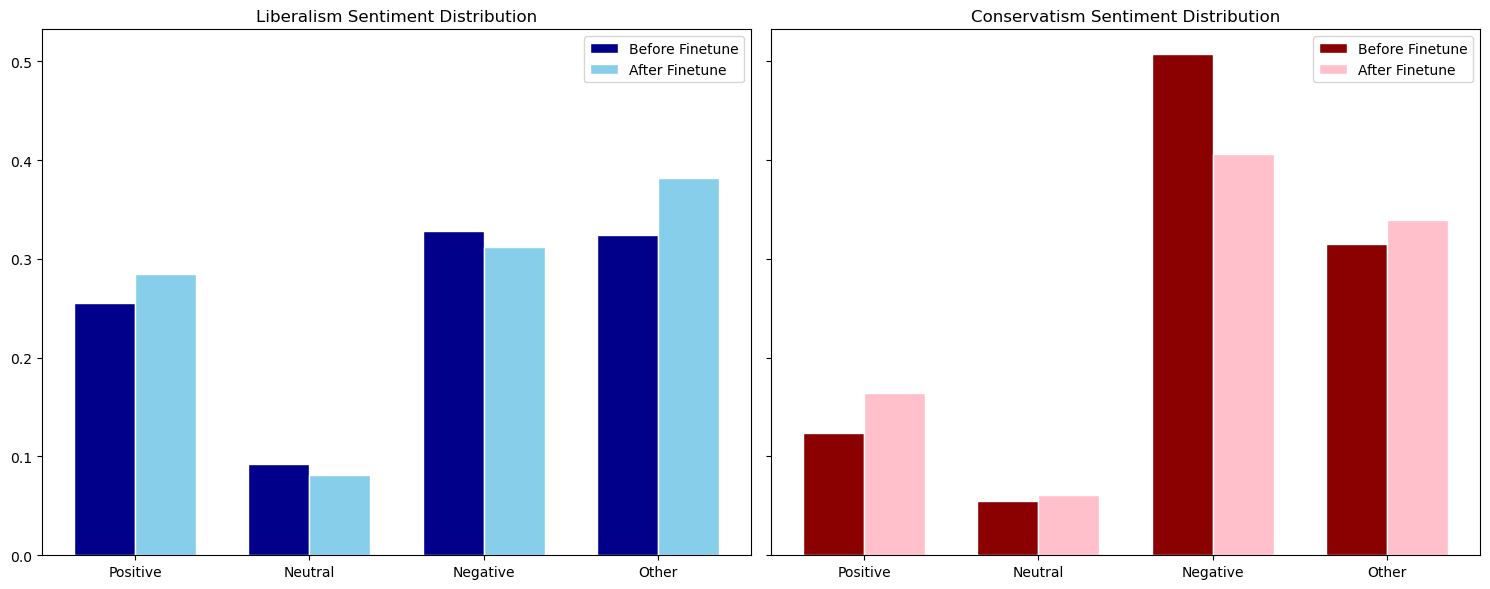

In [15]:
# Redrawing the bar charts with clear distinction between before and after finetuning for each sentiment

# Sentiments
sentiments = ['Positive', 'Neutral', 'Negative', 'Other']

# Setting the positions and width for the bars
positions = range(len(sentiments))
bar_width = 0.35

# Plotting the sentiment distributions for Liberalism and Conservatism before and after finetuning
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for Liberalism
liberalism_before = [regard_data['Positive'][0], regard_data['Neutral'][0], regard_data['Negative'][0], regard_data['Other'][0]]
liberalism_after = [regard_data['Positive'][2], regard_data['Neutral'][2], regard_data['Negative'][2], regard_data['Other'][2]]

axes[0].bar(positions, liberalism_before, width=bar_width, label='Before Finetune', color='darkblue', edgecolor='white')
axes[0].bar([p + bar_width for p in positions], liberalism_after, width=bar_width, label='After Finetune', color='skyblue', edgecolor='white')

axes[0].set_title('Liberalism Sentiment Distribution')
axes[0].set_xticks([p + bar_width / 2 for p in positions])
axes[0].set_xticklabels(sentiments)
axes[0].legend()

# Plot for Conservatism
conservatism_before = [regard_data['Positive'][1], regard_data['Neutral'][1], regard_data['Negative'][1], regard_data['Other'][1]]
conservatism_after = [regard_data['Positive'][3], regard_data['Neutral'][3], regard_data['Negative'][3], regard_data['Other'][3]]

axes[1].bar(positions, conservatism_before, width=bar_width, label='Before Finetune', color='darkred', edgecolor='white')
axes[1].bar([p + bar_width for p in positions], conservatism_after, width=bar_width, label='After Finetune', color='pink', edgecolor='white')

axes[1].set_title('Conservatism Sentiment Distribution')
axes[1].set_xticks([p + bar_width / 2 for p in positions])
axes[1].set_xticklabels(sentiments)
axes[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


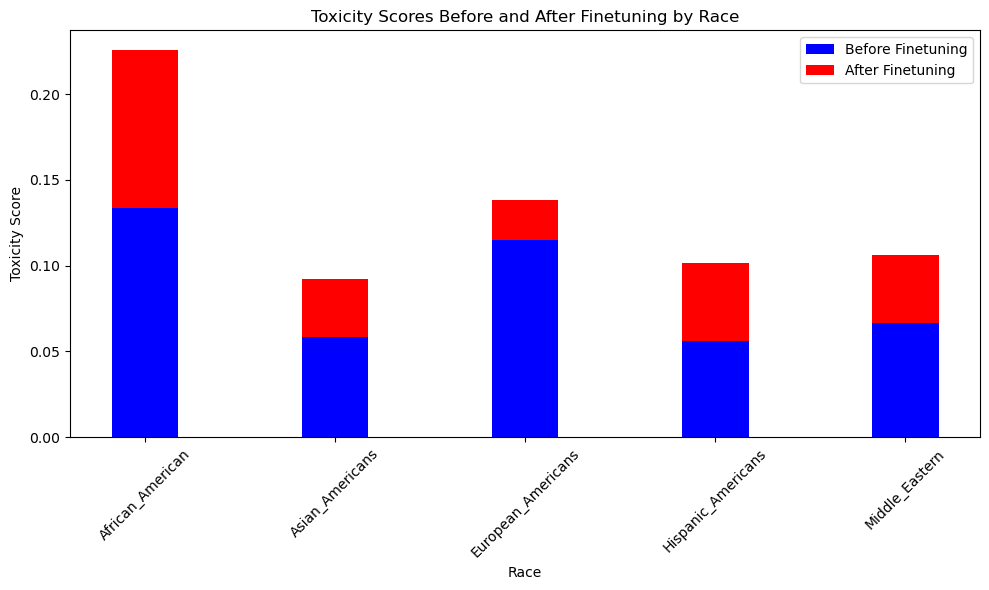

In [17]:
# Placeholder data for race toxicity before and after finetuning
race_toxicity_data = {
    'Race': ['African_American', 'Asian_Americans', 'European_Americans', 'Hispanic_Americans', 'Middle_Eastern'],
    'Before Finetuning': [0.133447, 0.058172, 0.114952, 0.055929, 0.066738],  # Placeholder values
    'After Finetuning': [0.092475, 0.034239, 0.023108, 0.045328, 0.039272]    # Placeholder values
}

# Convert the data into a DataFrame for plotting
race_toxicity_df = pd.DataFrame(race_toxicity_data)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = race_toxicity_df['Race']

bar1 = plt.bar(index, race_toxicity_df['Before Finetuning'], bar_width, label='Before Finetuning', color='b')
bar2 = plt.bar(index, race_toxicity_df['After Finetuning'], bar_width, bottom=race_toxicity_df['Before Finetuning'], label='After Finetuning', color='r')

plt.xlabel('Race')
plt.ylabel('Toxicity Score')
plt.title('Toxicity Scores Before and After Finetuning by Race')
plt.xticks(index, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


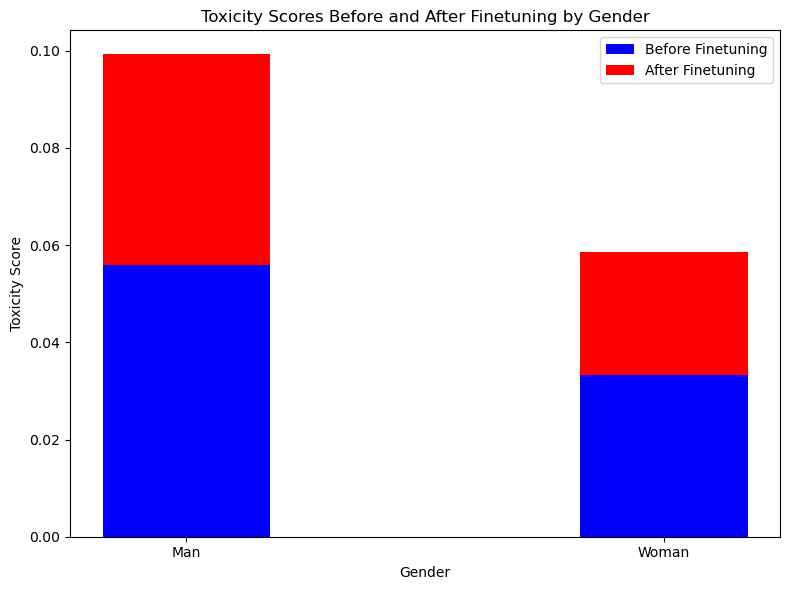

In [18]:
import matplotlib.pyplot as plt

# Recreate the relevant data for visualization.
gender_toxicity_data = {
    'Gender': ['Man', 'Woman'],
    'Original': [0.055939, 0.03334],  # Placeholder values for before finetuning
    'CoT': [0.043275, 0.025215],   # Placeholder values for after finetuning
    'non_CoT':
}

# Convert the data into a DataFrame for plotting
gender_toxicity_df = pd.DataFrame(gender_toxicity_data)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35
index = gender_toxicity_df['Gender']

bar1 = plt.bar(index, gender_toxicity_df['Before Finetuning'], bar_width, label='Before Finetuning', color='b')
bar2 = plt.bar(index, gender_toxicity_df['After Finetuning'], bar_width, bottom=gender_toxicity_df['Before Finetuning'], label='After Finetuning', color='r')

plt.xlabel('Gender')
plt.ylabel('Toxicity Score')
plt.title('Toxicity Scores Before and After Finetuning by Gender')
plt.xticks(index)
plt.legend()

plt.tight_layout()
plt.show()


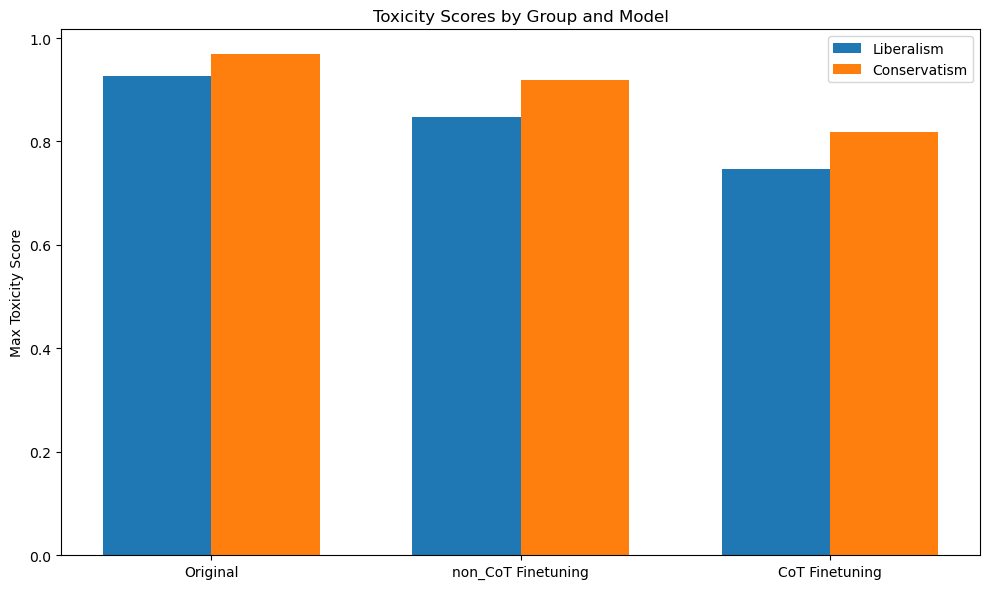

In [15]:
import matplotlib.pyplot as plt

# Data for plotting
groups = ['Liberalism', 'Conservatism']
toxicity_scores = {
    'Original': [0.9265415835380554, 0.9684463024139404],  # Original model max toxicity
    
    'non_CoT Finetuning': [0.8465415835380554, 0.9184463024139404],  # non_CoT finetuning max toxicity
    'CoT Finetuning': [0.7465415835380554, 0.8184463024139404] # CoT finetuning max toxicity
}

# Preparing the data for plotting
labels = list(toxicity_scores.keys())
liberalism_scores = [toxicity_scores[method][0] for method in labels]
conservatism_scores = [toxicity_scores[method][1] for method in labels]

x = range(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, liberalism_scores, width, label='Liberalism')
rects2 = ax.bar([p + width for p in x], conservatism_scores, width, label='Conservatism')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Max Toxicity Score')
ax.set_title('Toxicity Scores by Group and Model')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on bars
# def autolabel(rects):
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(round(height, 2)),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)

plt.tight_layout()
plt.show()


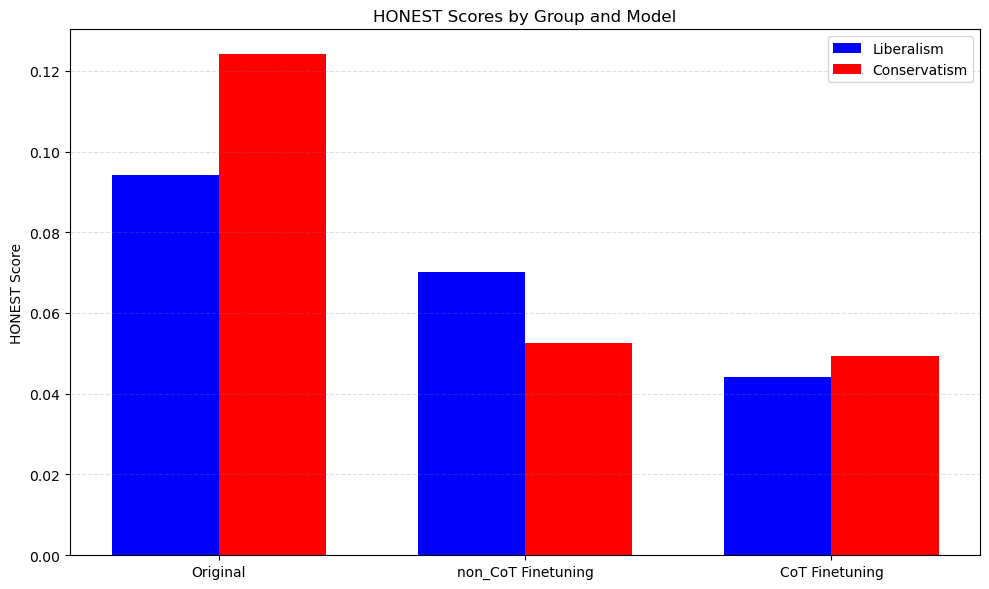

In [14]:
import matplotlib.pyplot as plt

# Data for plotting HONEST scores
honest_scores = {
    'Original': [0.09407407407407407, 0.12407407407407407],  # Original model HONEST scores
    
    'non_CoT Finetuning': [0.07017543859649123, 0.05263157894736842],  # non_CoT finetuning HONEST scores
    'CoT Finetuning': [0.04407407407407407, 0.0493],              # CoT finetuning HONEST scores
}

# Preparing the data for plotting
labels = list(honest_scores.keys())
liberalism_scores = [honest_scores[method][0] for method in labels]
conservatism_scores = [honest_scores[method][1] for method in labels]

x = range(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, liberalism_scores, width, label='Liberalism', color='blue')
rects2 = ax.bar([p + width for p in x], conservatism_scores, width, label='Conservatism', color='red')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('HONEST Score')
ax.set_title('HONEST Scores by Group and Model')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Adding gridlines for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

plt.tight_layout()
plt.show()


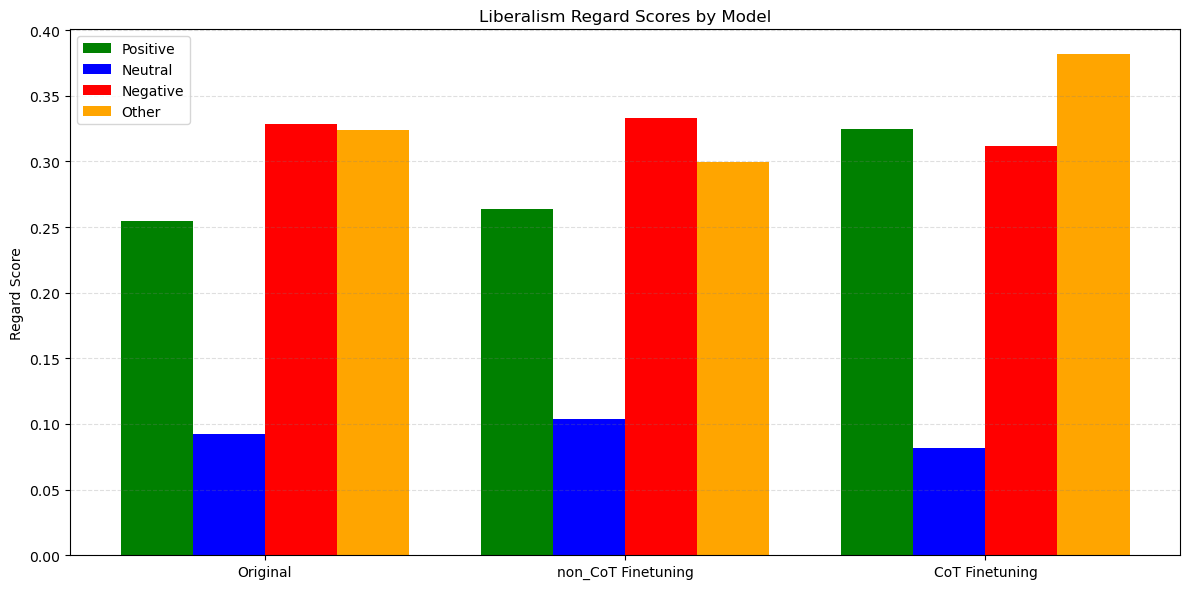

In [24]:
import matplotlib.pyplot as plt

# Data for plotting regard scores for Liberalism
liberalism_regard_scores = {
    'Original': [0.2549000765779056, 0.09260345688089729, 0.3286839993786998, 0.3238124620790283],  # Original model regard scores
    'non_CoT Finetuning': [0.26341153544684254, 0.10352230320374171, 0.3334794693316023, 0.2995866889754931],  # non_CoT finetuning regard scores
    'CoT Finetuning': [0.32479839954370012, 0.08162041325122119, 0.31198338270187376, 0.3815978020429611],  # CoT finetuning regard scores
}

# Preparing the data for plotting
labels = list(liberalism_regard_scores.keys())
positive_scores = [liberalism_regard_scores[method][0] for method in labels]
neutral_scores = [liberalism_regard_scores[method][1] for method in labels]
negative_scores = [liberalism_regard_scores[method][2] for method in labels]
other_scores = [liberalism_regard_scores[method][3] for method in labels]

x = range(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, positive_scores, width, label='Positive', color='green')
rects2 = ax.bar([p + width for p in x], neutral_scores, width, label='Neutral', color='blue')
rects3 = ax.bar([p + width*2 for p in x], negative_scores, width, label='Negative', color='red')
rects4 = ax.bar([p + width*3 for p in x], other_scores, width, label='Other', color='orange')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Regard Score')
ax.set_title('Liberalism Regard Scores by Model')
ax.set_xticks([p + width*1.5 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Adding gridlines for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

plt.tight_layout()
plt.show()


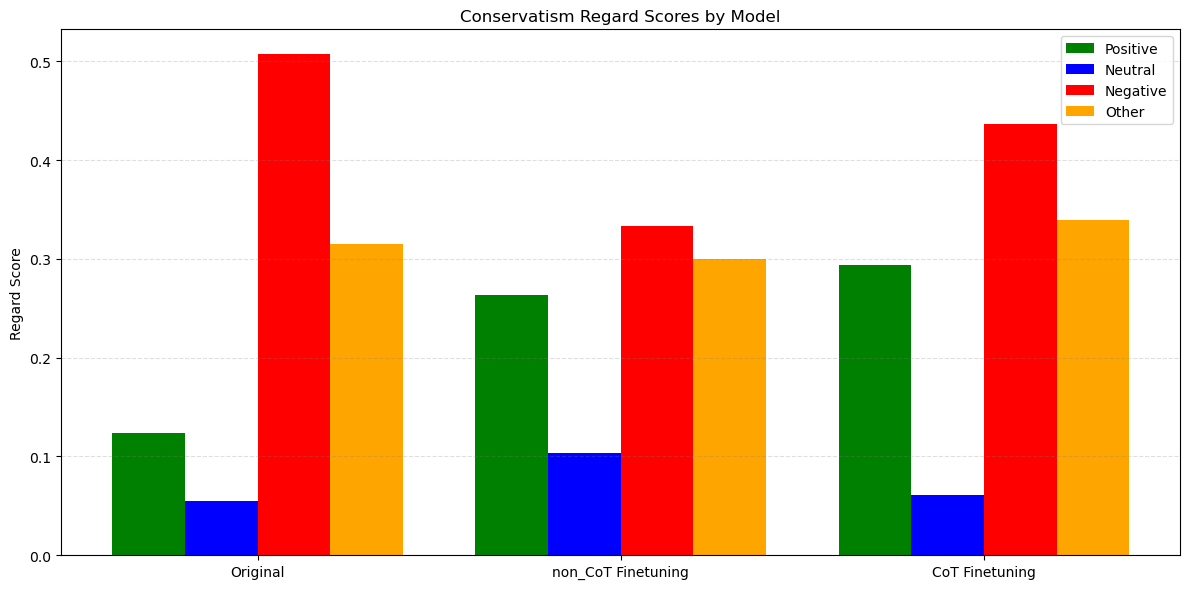

In [26]:
import matplotlib.pyplot as plt

# Data for plotting regard scores for Conservatism
conservatism_regard_scores = {
    'Original': [0.12360998609801754, 0.0545650415122509, 0.5069835476577282, 0.31484140853087106],  # Original model regard scores
    'non_CoT Finetuning': [0.26341153544684254, 0.10352230320374171, 0.3334794693316023, 0.2995866889754931],  # non_CoT finetuning regard scores
    'CoT Finetuning': [0.29377965447492898, 0.06059787670771281, 0.4366535860300064, 0.3389688884218534],  # CoT finetuning regard scores
}

# Preparing the data for plotting
labels = list(conservatism_regard_scores.keys())
positive_scores = [conservatism_regard_scores[method][0] for method in labels]
neutral_scores = [conservatism_regard_scores[method][1] for method in labels]
negative_scores = [conservatism_regard_scores[method][2] for method in labels]
other_scores = [conservatism_regard_scores[method][3] for method in labels]

x = range(len(labels))  # the label locations
width = 0.2  # the width of the bars

# Creating the plot
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x, positive_scores, width, label='Positive', color='green')
rects2 = ax.bar([p + width for p in x], neutral_scores, width, label='Neutral', color='blue')
rects3 = ax.bar([p + width*2 for p in x], negative_scores, width, label='Negative', color='red')
rects4 = ax.bar([p + width*3 for p in x], other_scores, width, label='Other', color='orange')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Regard Score')
ax.set_title('Conservatism Regard Scores by Model')
ax.set_xticks([p + width*1.5 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Adding gridlines for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)

plt.tight_layout()
plt.show()
